In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import itertools as itt
from scipy.linalg import sqrtm
from scipy.stats import norm

Let $u = s'_1, s_1, a_1, \, v = s'_2, s_2, a_2$. We modify the standard Squared-Exponential (SE) kernel with scale $\sigma$ by incorporating $\alpha \in (-1, 1)$, which kicks in whenever $a_1 \neq a_2$:
\begin{equation}
  K \left( u, v; \alpha, \sigma \right) = 
    \left\{
      \begin{array}
        \mbox{exp} \left( - \frac{(s'_1 - s_1)^2 + (s'_2 - s_2)^2}{2 \sigma^2}  \right) \, \mbox{if} \; a_1 = a_2 \\
        \alpha \, \mbox{exp} \left( - \frac{(s'_1 - s_1)^2 + (s'_2 - s_2)^2}{2 \sigma^2} \right) \, o.w.
      \end{array}
    \right\}
\end{equation}

In [ ]:
# data generation
n_patients = 100
T = 50
BP_upper = 125
BP_lower = 115
mean_drop_BP = 4
mean_raise_BP = 4
state_data = np.array([[None]*T]*n_patients)
action_data = np.array([[None]*(T - 1)]*n_patients)
for n in range(n_patients):
  state_data[n][0] = np.random.normal(loc = 130, scale = 1)
  for t in range(1,T):
    temp = state_data[n][t - 1]
    if temp > BP_upper:
      action_data[n][t - 1] = 1
      state_data[n][t] = np.random.normal(loc = temp - mean_drop_BP, scale = 3)
    elif temp < BP_lower:
      action_data[n][t - 1] = 1
      state_data[n][t] = np.random.normal(loc = temp + mean_raise_BP, scale = 3)
    else:
      action_data[n][t - 1] = 0
      state_data[n][t] = np.random.normal(loc = temp, scale = 3)

In [ ]:
np.mean([sum(a) for a in action_data])

12.39

In [ ]:
data = []
for n in range(n_patients):
  for t in range(T - 1):
    data = data + [[state_data[n][t + 1], state_data[n][t], action_data[n][t]]]
data = np.array(data)

In [ ]:
data[:20]

array([[125.314848  , 129.33080197,   1.        ],
       [117.94255009, 125.314848  ,   1.        ],
       [118.84241648, 117.94255009,   0.        ],
       [121.34049199, 118.84241648,   0.        ],
       [120.84752743, 121.34049199,   0.        ],
       [124.76531975, 120.84752743,   0.        ],
       [128.10502965, 124.76531975,   0.        ],
       [124.25466209, 128.10502965,   1.        ],
       [123.70967582, 124.25466209,   0.        ],
       [127.11596923, 123.70967582,   0.        ],
       [126.00245102, 127.11596923,   1.        ],
       [118.20075006, 126.00245102,   1.        ],
       [116.81309613, 118.20075006,   0.        ],
       [122.86412046, 116.81309613,   0.        ],
       [125.41682522, 122.86412046,   0.        ],
       [121.5673812 , 125.41682522,   1.        ],
       [124.05546553, 121.5673812 ,   0.        ],
       [122.65381794, 124.05546553,   0.        ],
       [120.11869442, 122.65381794,   0.        ],
       [119.23037369, 120.11869

In [ ]:
# SE kernel 
def Kernel(u, v, alpha = 0.2, scale = 5):
  val = np.exp(- ((u[0] - v[0])**2 + (u[1] - v[1])**2) / (2*scale**2))
  if u[2] == v[2]:
    return val
  else:
    return alpha*val

In [ ]:
Kernel(data[7], data[2])

0.014110927550165991

In [ ]:
grid_size_temp = 5
state_grid = np.linspace(start = np.min(state_data), stop = np.max(state_data), num = grid_size_temp)
grid = [list(v) for v in itt.product(state_grid, state_grid, [0, 1])]
grid_size = 2*grid_size_temp**2

In [ ]:
grid[10:20]

[[112.33831508862069, 104.90851510535973, 0],
 [112.33831508862069, 104.90851510535973, 1],
 [112.33831508862069, 112.33831508862069, 0],
 [112.33831508862069, 112.33831508862069, 1],
 [112.33831508862069, 119.76811507188165, 0],
 [112.33831508862069, 119.76811507188165, 1],
 [112.33831508862069, 127.19791505514262, 0],
 [112.33831508862069, 127.19791505514262, 1],
 [112.33831508862069, 134.62771503840358, 0],
 [112.33831508862069, 134.62771503840358, 1]]

In [ ]:
kernel_mat = np.array([[None]*grid_size]*grid_size, dtype = 'float')
for i in range(grid_size):
  for j in range(grid_size):
    kernel_mat[i][j] = Kernel(grid[i], grid[j])

In [ ]:
kernel_mat

array([[1.00000000e+00, 2.00000000e-01, 3.31529476e-01, ...,
        2.06102700e-13, 4.53637258e-16, 9.07274516e-17],
       [2.00000000e-01, 1.00000000e+00, 6.63058952e-02, ...,
        1.03051350e-12, 9.07274516e-17, 4.53637258e-16],
       [3.31529476e-01, 6.63058952e-02, 1.00000000e+00, ...,
        5.14603746e-11, 1.03051350e-12, 2.06102700e-13],
       ...,
       [2.06102700e-13, 1.03051350e-12, 5.14603746e-11, ...,
        1.00000000e+00, 6.63058952e-02, 3.31529476e-01],
       [4.53637258e-16, 9.07274516e-17, 1.03051350e-12, ...,
        6.63058952e-02, 1.00000000e+00, 2.00000000e-01],
       [9.07274516e-17, 4.53637258e-16, 2.06102700e-13, ...,
        3.31529476e-01, 2.00000000e-01, 1.00000000e+00]])

In [ ]:
np.linalg.det(kernel_mat)

1.4803555162382432e-05

In [ ]:
np.real(sqrtm(kernel_mat))

array([[ 9.65982647e-01,  9.75840639e-02,  1.66996707e-01, ...,
        -5.52171176e-08,  1.07972007e-07,  1.09073890e-08],
       [ 9.75840639e-02,  9.65982647e-01,  1.68700932e-02, ...,
        -5.46593113e-07,  1.09073883e-08,  1.07972008e-07],
       [ 1.66996707e-01,  1.68700932e-02,  9.51053187e-01, ...,
         3.11594987e-07, -5.46593113e-07, -5.52171171e-08],
       ...,
       [-5.52171174e-08, -5.46593113e-07,  3.11594987e-07, ...,
         9.51053187e-01,  1.68700932e-02,  1.66996707e-01],
       [ 1.07972007e-07,  1.09073883e-08, -5.46593113e-07, ...,
         1.68700932e-02,  9.65982647e-01,  9.75840639e-02],
       [ 1.09073890e-08,  1.07972007e-07, -5.52171171e-08, ...,
         1.66996707e-01,  9.75840639e-02,  9.65982647e-01]])

In [ ]:
inv_sqr_mat = np.linalg.inv(np.real(sqrtm(kernel_mat)))  

In [ ]:
def kernel_vec(u):
  return np.array([Kernel(u, v) for v in grid])

In [ ]:
kernel_vec([110, 100, 1])

array([7.35512607e-02, 3.67756303e-01, 5.66990642e-03, 2.83495321e-02,
       4.80403271e-05, 2.40201636e-04, 4.47383864e-08, 2.23691932e-07,
       4.57929868e-12, 2.28964934e-11, 1.10729757e-01, 5.53648783e-01,
       8.53591566e-03, 4.26795783e-02, 7.23236241e-05, 3.61618120e-04,
       6.73526271e-08, 3.36763135e-07, 6.89403041e-12, 3.44701520e-11,
       1.83224212e-02, 9.16121062e-02, 1.41243553e-03, 7.06217765e-03,
       1.19673695e-05, 5.98368473e-05, 1.11448200e-08, 5.57241000e-08,
       1.14075325e-12, 5.70376623e-12, 3.33231215e-04, 1.66615608e-03,
       2.56880683e-05, 1.28440342e-04, 2.17651424e-07, 1.08825712e-06,
       2.02691657e-10, 1.01345828e-09, 2.07469627e-14, 1.03734814e-13,
       6.66120479e-07, 3.33060239e-06, 5.13497763e-08, 2.56748881e-07,
       4.35079500e-10, 2.17539750e-09, 4.05175317e-13, 2.02587659e-12,
       4.14726356e-17, 2.07363178e-16])

In [ ]:
X = np.dot([kernel_vec(u) for u in data], inv_sqr_mat)

In [ ]:
X[50]

array([ 1.03580485e-04,  1.04637539e-05, -1.63113676e-04, -1.64778274e-05,
        7.51835667e-03,  7.59508258e-04,  5.70451832e-03,  5.76273376e-04,
       -2.95015769e-04, -2.98026447e-05, -1.10486088e-04, -1.11613614e-05,
        1.73988294e-04,  1.75763870e-05, -8.01959767e-03, -8.10143882e-04,
       -6.08483262e-03, -6.14692921e-04,  3.14684162e-04,  3.17895560e-05,
        8.11227072e-03,  8.19505761e-04, -1.27748224e-02, -1.29051913e-03,
        5.88826599e-01,  5.94835660e-02,  4.46769457e-01,  4.51328804e-02,
       -2.31051996e-02, -2.33409915e-03,  5.62288418e-03,  5.68026653e-04,
       -8.85465353e-03, -8.94501655e-04,  4.08135266e-01,  4.12300346e-02,
        3.09670744e-01,  3.12830979e-02, -1.60149810e-02, -1.61784162e-03,
       -3.12445470e-04, -3.15634021e-05,  4.92024430e-04,  4.97045610e-05,
       -2.26787554e-02, -2.29101954e-03, -1.72074007e-02, -1.73830047e-03,
        8.89900646e-04,  8.98982211e-05])

In [ ]:
len(data) == len(X)

True

In [ ]:
V = np.linalg.inv(np.identity(grid_size) + np.dot(X.transpose(), X))

In [ ]:
V

array([[ 9.95673447e-01, -2.94198745e-02,  8.27695838e-03, ...,
         1.18190371e-04, -1.63013821e-04, -3.23533920e-04],
       [-2.94198745e-02,  7.09931449e-01,  1.50468431e-03, ...,
         1.81085151e-03, -3.93960307e-04, -2.85998383e-03],
       [ 8.27695838e-03,  1.50468431e-03,  4.00721748e-01, ...,
         5.68702928e-04,  1.54897587e-03, -2.03482998e-03],
       ...,
       [ 1.18190371e-04,  1.81085151e-03,  5.68702928e-04, ...,
         2.20011242e-01, -1.62653893e-02, -1.60924383e-01],
       [-1.63013821e-04, -3.93960307e-04,  1.54897587e-03, ...,
        -1.62653893e-02,  9.89671624e-01, -6.84086423e-02],
       [-3.23533920e-04, -2.85998383e-03, -2.03482998e-03, ...,
        -1.60924383e-01, -6.84086423e-02,  3.14488942e-01]])

In [ ]:
S = np.dot(V, X.transpose())

In [ ]:
S

array([[-6.36927876e-05, -1.52149455e-04,  2.09285650e-05, ...,
        -3.76995678e-05, -1.80564702e-04,  2.92191899e-04],
       [-6.41385380e-04, -1.45570082e-03, -1.01475169e-04, ...,
        -3.44718631e-04, -1.75598646e-03, -1.35901910e-04],
       [-1.86899114e-04, -1.38639958e-05,  1.56299418e-03, ...,
        -9.68734091e-05, -3.00226337e-05,  2.87335446e-03],
       ...,
       [-7.44229110e-03,  1.74809515e-03,  8.26591120e-05, ...,
        -9.88464333e-03,  2.29382255e-03,  8.08230132e-05],
       [-4.40503792e-04, -3.33293835e-04,  5.46483789e-05, ...,
         6.16952361e-04, -3.72856455e-04,  1.55185645e-04],
       [-4.39389983e-03, -3.50393221e-03,  1.75421413e-04, ...,
         6.14133161e-03, -3.89875710e-03,  7.90018153e-05]])

In [ ]:
H = np.dot(X, S)

In [ ]:
H

array([[ 5.06492338e-03, -1.74954040e-04,  5.84506225e-06, ...,
         2.66495507e-03, -1.82975900e-04, -5.95131488e-07],
       [-1.74954040e-04,  8.67537881e-03, -1.70218473e-05, ...,
        -6.66027020e-04,  8.61179675e-03, -8.81299024e-06],
       [ 5.84506225e-06, -1.70218473e-05,  1.17011575e-03, ...,
         6.41118223e-06, -1.91907157e-05,  7.90455769e-04],
       ...,
       [ 2.66495507e-03, -6.66027020e-04,  6.41118223e-06, ...,
         4.17241081e-03, -7.45852923e-04,  2.22088100e-06],
       [-1.82975900e-04,  8.61179675e-03, -1.91907157e-05, ...,
        -7.45852923e-04,  8.88390815e-03, -7.00369601e-06],
       [-5.95131488e-07, -8.81299024e-06,  7.90455769e-04, ...,
         2.22088100e-06, -7.00369601e-06,  1.19925804e-03]])

In [ ]:
H_diag = np.array([H[i][i] for i in range(len(data))])
H_var = 1 + H_diag/(1 - H_diag)

In [ ]:
H_var

array([1.00509071, 1.0087513 , 1.00117149, ..., 1.00418989, 1.00896354,
       1.0012007 ])

In [ ]:
def trunc_norm_draw(loc, scale, action):
  if action == 1:
    inv_cdf = lambda t : norm.ppf(norm.cdf(0, loc = loc, scale = scale) + t*(1 - norm.cdf(0, loc = loc, scale = scale)), loc = loc, scale = scale)
  else:
    inv_cdf = lambda t : norm.ppf(t*(norm.cdf(0, loc = loc, scale = scale)), loc = loc, scale = scale)
  return inv_cdf(np.random.uniform(low = 0, high = 1))

In [ ]:
trunc_norm_draw(loc = 2, scale = 1, action = 1)

1.0313598445677634

In [ ]:
n_iter = 200
Y_mat = np.array([[None]*len(data)]*n_iter)
Y = np.random.normal(size = len(data))
B = np.dot(S, Y)
for j in range(n_iter):
  Y_mat[j] = Y
  for i in range(len(data)):
    w = H_var[i] - 1
    mu = np.dot(X[i], B)*(1 + w) - w*Y[i]
    Y_old = Y[i]
    Y[i] = trunc_norm_draw(loc = mu, scale = 1 + w, action = data[i][2])
    B = B + np.dot(np.array([s[i] for s in S]), Y[i] - Y_old)
Y_final = Y_mat[-1]

In [ ]:
Y_mat_last = Y_mat[-n_iter//2:]
beta_mat = np.array([np.random.default_rng().multivariate_normal(mean = np.dot(S, y), cov = V) for y in Y_mat_last])
beta_final = np.array([np.mean(b) for b in beta_mat.transpose()])

In [ ]:
beta_final

array([ 0.18370681,  0.55149903, -0.7450539 ,  0.78640766, -0.90709338,
       -0.0311004 , -0.1874328 , -0.07683796,  0.12951991, -0.36095441,
        0.26881703,  1.13997329, -1.70009327,  2.07459035, -2.26994571,
        0.76180915,  0.09008572,  1.17023662, -0.03858853,  0.1264389 ,
        0.17240362,  0.20730186, -0.93466486,  2.12525162, -2.80565   ,
        1.38023236, -2.00888234,  3.64091992,  0.17290377,  1.01694884,
       -0.01431408,  0.1717775 ,  0.44679387,  1.37332277, -2.59379494,
        0.40011846, -3.03953331,  2.39478093,  0.15607378,  1.26117652,
        0.11518956, -0.02894059,  0.09205869, -0.06452682, -0.51721384,
        0.00479966, -0.48214713,  1.08787109,  0.16493526,  0.98789701])

In [ ]:
beta_mat

array([[-0.7390928673969577, 1.2976927161930245, 0.3066095685281556, ...,
        3.060671762874006, -0.33373894688606703, -0.018197644771842103],
       [-1.3032595631664599, 1.1538982768924702, -0.8676942390936513,
        ..., 0.9936497124996999, 0.7883964165973207, 1.1135594164122045],
       [0.2218382565523862, 2.278045940993039, -0.5638222546264104, ...,
        1.7172141441675275, 1.2909168189669584, 0.8586982507799824],
       ...,
       [1.1732888574754718, -0.15745548139486823, -0.9186925832082077,
        ..., 0.8655826634330746, 0.9495899452543862, -0.1004633864893083],
       [0.5929941843418484, 1.0119343467026258, -1.5943184239538515, ...,
        -1.6426251895356327, -0.20621576979705109, 0.7817837222360676],
       [0.12383788587026236, 2.4351265897805376, -0.503700253052072, ...,
        -0.12431028200161495, 2.114263789352641, 0.8757843518717437]],
      dtype=object)

In [ ]:
# grid on which estimated rewards will be plotted
# for conventional plotting, will not work with MESHGRID
test_grid_size_temp = 20
test_state_grid = np.linspace(start = np.min(state_data), stop = np.max(state_data), num = test_grid_size_temp)
test_grid = [list(v) for v in itt.product(test_state_grid, test_state_grid, [0, 1])]
test_grid_size = 2*test_grid_size_temp**2

X_test = np.dot([kernel_vec(u) for u in test_grid], inv_sqr_mat)

r_hat = np.dot(X_test, beta_final)

In [ ]:
# reward definition
def r_hat(u):
  x_vec = np.dot(kernel_vec(u), inv_sqr_mat)
  return np.dot(x_vec, beta_final)

In [ ]:
r_hat([105, 100, 1])

0.41914968654374896

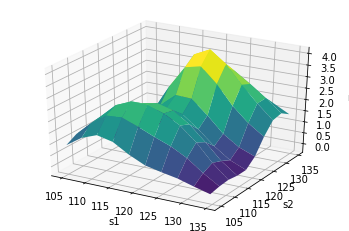

In [ ]:
# MESHGRID plotting for ACTION = 1
test_mesh_size = 10
s = np.linspace(start = np.min(state_data), stop = np.max(state_data), num = test_mesh_size)
X, Y = np.meshgrid(s, s)
r0 = np.array([[r_hat(np.array(list(e) + [0])) for e in zip(a[0], a[1])] for a in [list(b) for b in zip(X, Y)]])
r1 = np.array([[r_hat(np.array(list(e) + [1])) for e in zip(a[0], a[1])] for a in [list(b) for b in zip(X, Y)]])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, r1, cmap='viridis')
ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('r');

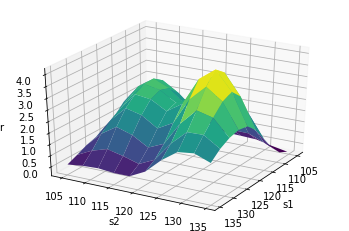

In [ ]:
# rotated view
ax.view_init(30, 30)
fig

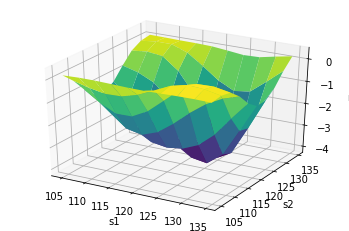

In [ ]:
# MESHGRID plotting for ACTION = 0
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, r0, cmap='viridis')
ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('r');

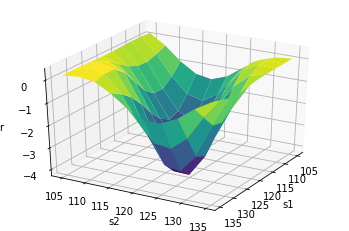

In [ ]:
# rotated view
ax.view_init(30, 30)
fig